In [ ]:
!pip install prophet
!pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached PyMeeus-0.5.12-py3-none-any.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
ERROR: ERROR: Failed 

In [ ]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel('Data_Science_Assignment.xlsx', sheet_name='data')
df_dict = pd.read_excel('Data_Science_Assignment.xlsx', sheet_name='dictionary')

In [ ]:
df['product'].unique()

array([54118,  8746, 47153, 42419, 56825])

In [ ]:
df_dict.style.set_properties(subset=['Description'], **{'width': '250px'})

,Variable,Description
0,week,Starting date of the week represented in MM/DD/YYYY
1,product,Name of the product
2,orders,Number of orders placed for that product in that week
3,brand,Brand of the product
4,views,Number of page views for the product
5,cart_adds,Number of customers who added the product to their cart
6,price,Price of the product listed for that week
7,inventory,Available inventory of the product at the end of that week


In [ ]:
print(df.shape)

(260, 8)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   week       260 non-null    object 
 1   product    260 non-null    int64  
 2   orders     259 non-null    float64
 3   brand      260 non-null    object 
 4   views      259 non-null    float64
 5   cart_adds  259 non-null    float64
 6   price      259 non-null    float64
 7   inventory  260 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 16.4+ KB


In [ ]:
df['product'] = df['product'].astype('str')

# Preprocessing

In [ ]:
df.week = pd.to_datetime(df.week)

In [ ]:
print(df.isna().sum())
print(df[df['orders'].isna()])

week         0
product      0
orders       1
brand        0
views        1
cart_adds    1
price        1
inventory    0
dtype: int64
         week product  orders            brand  views  cart_adds  price  \
60 2020-02-02    8746     NaN  Big Cable Brand    NaN        NaN    NaN   

    inventory  
60         85  


In [ ]:
df.dropna(inplace=True)

In [ ]:
# inventory at the start of the week as per original data (inv_sow)
df['inv_sow'] = df.groupby(['product'])['inventory'].shift(1)
df.dropna(inplace=True)

In [ ]:
#Quantity of inventory replenished as per original data
df['inv_rep'] = df.inventory + df.orders - df.inv_sow

In [ ]:
# Assuming surplus inventory(end of week) holding cost is 10% of the potential revenue
inv_hld_cst = 0.1
df['inv_cost'] = round(df.price * df.inventory * inv_hld_cst, 2)

In [ ]:
df['revenue'] = df.price * df.orders

In [ ]:
convert_dict = {'orders': int, 'views': int, 'cart_adds': int, 'inv_sow': int, 'inv_rep': int}
df = df.astype(convert_dict)

# EDA

In [ ]:
df.head()

,week,product,orders,brand,views,cart_adds,price,inventory,inv_sow,inv_rep,inv_cost,revenue
1,2019-12-15,54118,36,Big Cable Brand,3228,114,29.99,122,158,0,365.88,1079.64
2,2019-12-22,54118,51,Big Cable Brand,5259,108,29.99,71,122,0,212.93,1529.49
3,2019-12-29,54118,38,Big Cable Brand,3574,50,24.99,33,71,0,82.47,949.62
4,2020-01-05,54118,33,Big Cable Brand,5970,66,34.99,0,33,0,0.00,1154.67
5,2020-01-12,54118,0,Big Cable Brand,2091,0,44.99,0,0,0,0.00,0.00


In [ ]:
def trend(prd):
    return df[(df['orders']>0) & ((df['inv_sow'] + df['inv_rep'])>=df['orders']) & (df['product']==prd)]

[Text(0.5, 0, 'week'), Text(0, 0.5, 'revenue ($)')]

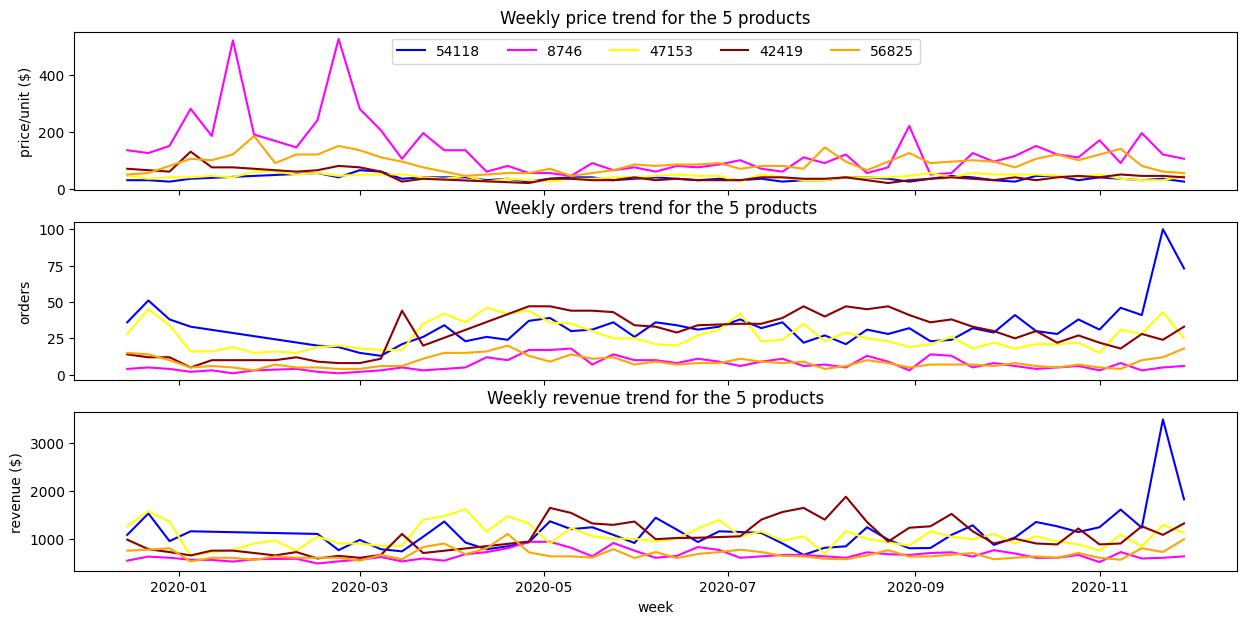

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15, 7))
for product, color in zip(['54118',  '8746', '47153', '42419', '56825'], ['blue', 'magenta', 'yellow', 'darkred', 'orange']):
    ax1.plot(trend(product).week, trend(product).price, color)
    ax2.plot(trend(product).week, trend(product).orders, color)
    ax3.plot(trend(product).week, trend(product).revenue, color)

ax1.legend(['54118',  '8746', '47153', '42419', '56825'], ncol=5, loc='upper center')
ax1.set_title('Weekly price trend for the 5 products')
ax1.set(ylabel='price/unit ($)')
ax2.set_title('Weekly orders trend for the 5 products')
ax2.set(ylabel='orders')
ax3.set_title('Weekly revenue trend for the 5 products')
ax3.set(xlabel='week', ylabel='revenue ($)')

In [ ]:
df_rev = round(pd.pivot_table(df, index='product', values='revenue', aggfunc=np.sum) * 100 / sum(df.revenue), 1)
df_rev.columns = ['revenue %']
df_rev.reset_index(inplace=True)

In [ ]:
df_ord = round(pd.pivot_table(df, index='product', values='orders', aggfunc=np.sum) * 100 / sum(df.orders), 1)
df_ord.columns = ['orders %']
df_ord.reset_index(inplace=True)

Text(0.5, 1.0, 'Orders(%) split among the 5 products')

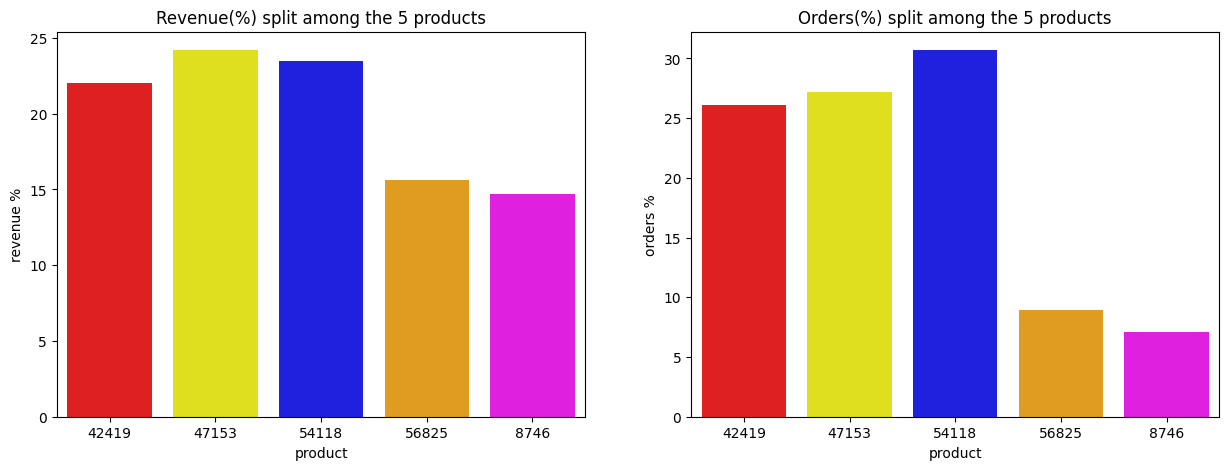

In [ ]:
fig = plt.figure(figsize=(15, 5))
my_pal = {'54118': 'blue', '8746': 'magenta', '47153': 'yellow', '42419': 'red', '56825': 'orange'}

ax = fig.add_subplot(1, 2, 1)
sns.barplot(x="product", y="revenue %", data=df_rev, palette=my_pal)
plt.title('Revenue(%) split among the 5 products')

ax = fig.add_subplot(1, 2, 2)
sns.barplot(x="product", y="orders %", data=df_ord, palette=my_pal)
plt.title('Orders(%) split among the 5 products')

[Text(0.5, 0, 'week'), Text(0, 0.5, 'count')]

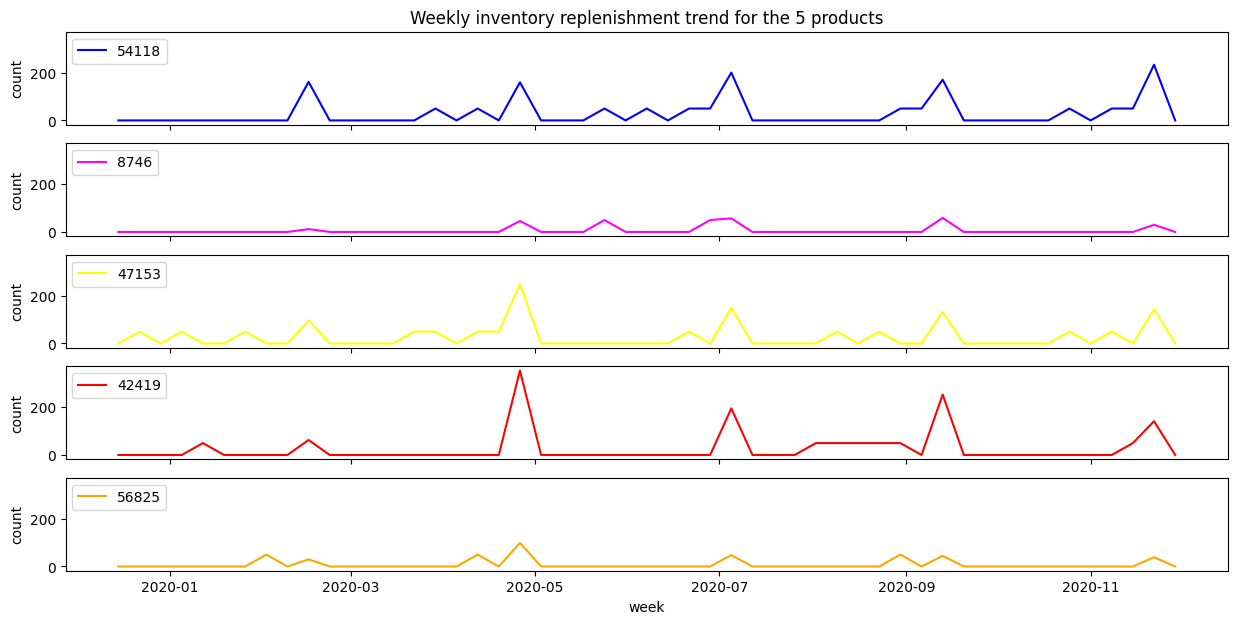

In [ ]:
def prd(prd):
    return df[df['product'] == prd]

fig, axes = plt.subplots(5, 1, sharex=True, sharey=True, figsize=(15, 7))

for ax, product, color in zip(axes, ['54118',  '8746', '47153', '42419', '56825'], ['blue', 'magenta', 'yellow', 'red', 'orange']):
    ax.plot(prd(product).week, prd(product).inv_rep, color)
    ax.legend([product], loc='upper left')
    ax.set(ylabel='count')

axes[0].set_title('Weekly inventory replenishment trend for the 5 products')
axes[-1].set(xlabel='week', ylabel='count')

In [ ]:
df_inv_rep = pd.pivot_table(df[df.inv_rep > 0], index='product', values='inv_rep', aggfunc=('count', 'median', 'max', 'min'))
df_inv_rep.rename(columns={'count': 'replenish_freq'}, inplace=True)
print(df_inv_rep[['replenish_freq', 'min', 'median', 'max']])

# Getting the weeks where peak inventory replenishment occurred
print(pd.DataFrame(df[df.inv_rep > 50]['week'].drop_duplicates()).set_index(np.arange(1, 6)))


         replenish_freq  min  median  max
product                                  
42419                12   50    50.0  355
47153                17   50    50.0  249
54118                16   50    50.0  234
56825                 8   30    49.0   99
8746                  7   12    50.0   59
        week
1 2020-02-16
2 2020-04-26
3 2020-07-05
4 2020-09-13
5 2020-11-22


[Text(0.5, 0, 'week'), Text(0, 0.5, 'count')]

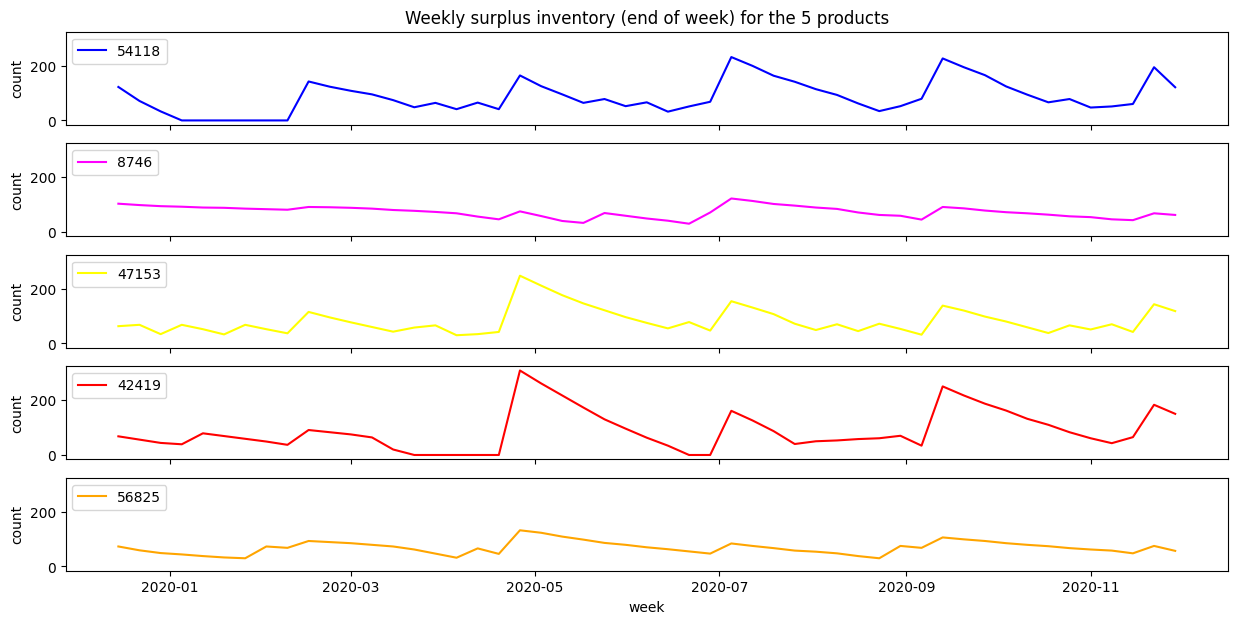

In [ ]:
fig, axes = plt.subplots(5, 1, sharex=True, sharey=True, figsize=(15, 7))

for ax, product, color in zip(axes, ['54118',  '8746', '47153', '42419', '56825'], ['blue', 'magenta', 'yellow', 'red', 'orange']):
    ax.plot(prd(product).week, prd(product).inventory, color)
    ax.legend([product], loc='upper left')
    ax.set(ylabel='count')

axes[0].set_title('Weekly surplus inventory (end of week) for the 5 products')
axes[-1].set(xlabel='week', ylabel='count')

In [ ]:
# Surplus inventory holding cost
df_inv_cst = round(pd.pivot_table(df, index='product', values='inv_cost', aggfunc=np.sum, margins=True, margins_name='Total'))
df_inv_cst.rename(columns={'inv_cost': 'surplus_inv_cost($)'}, inplace=True)
df_inv_cst2 = round(df_inv_cst.rename(columns={'surplus_inv_cost($)': 'surplus_inv_cost(%)'}) * 100 / sum(df.inv_cost))
df_inv_cst = df_inv_cst.join(df_inv_cst2)
print(df_inv_cst)

# Weeks with zero orders due to inventory stockout
print(df[df.orders == 0])

# Weeks where orders were constrained due to limited inventory
print(df[(df.orders > 0) & ((df.inv_sow + df.inv_rep) == df.orders)])

         surplus_inv_cost($)  surplus_inv_cost(%)
product                                          
42419                18652.0                 14.0
47153                16836.0                 13.0
54118                15866.0                 12.0
56825                30871.0                 23.0
8746                 52276.0                 39.0
Total               134501.0                100.0
          week product  orders               brand  views  cart_adds  price  \
5   2020-01-12   54118       0     Big Cable Brand   2091          0  44.99   
6   2020-01-19   54118       0     Big Cable Brand   4476          0  29.99   
7   2020-01-26   54118       0     Big Cable Brand   1466          0  34.99   
8   2020-02-02   54118       0     Big Cable Brand   3829          0  54.99   
9   2020-02-09   54118       0     Big Cable Brand   3215          0  29.99   
172 2020-03-29   42419       0  Little Cable Brand   4338          0  19.99   
173 2020-04-05   42419       0  Little Cable Br

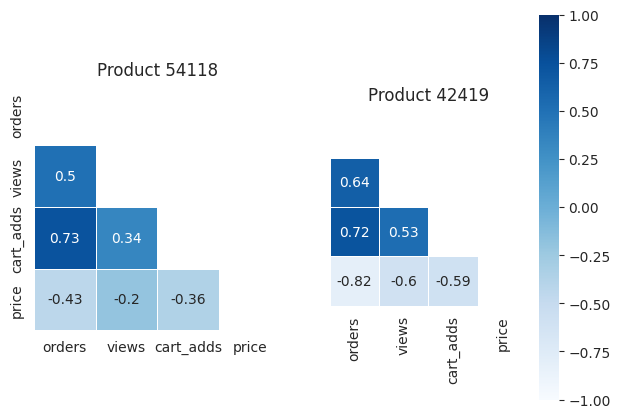

In [ ]:
# Correlation between orders, views & cart adds for products 54118 & 42419

df_corr_54118 = round(trend('54118')[['orders', 'views', 'cart_adds', 'price']].corr(),2)
df_corr_42419 = round(trend('42419')[['orders', 'views', 'cart_adds', 'price']].corr(),2)

mask = np.zeros_like(df_corr_54118)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(7, 5))
    sns.heatmap(df_corr_54118, mask=mask, vmin=-1, vmax=1, square=True, annot=True, linewidths=.5, cmap=plt.cm.Blues, ax=ax[0], cbar=False)
    ax[0].set_title('Product 54118')
    sns.heatmap(df_corr_42419, mask=mask, vmin=-1, vmax=1, square=True, annot=True, linewidths=.5, cmap=plt.cm.Blues, ax=ax[1], cbar=True)
    ax[1].set_title('Product 42419')

# Order prediction model

In [ ]:
# Function to build a random forest regression model to predict orders based on views, cart adds & price of the product

def ord_pred(prd):

    # Getting the product data for model building
    df_rf = trend(prd)[['orders', 'views', 'cart_adds', 'price']]

    # Seperating the Y-variable i.e. orders from the X-variables i.e predictors
    X = df_rf.drop(['orders'], axis=1)
    Y = df_rf['orders']

    # Splitting data into train & test
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.2, random_state=123)

    # Instantiate model with 3 decision trees
    rf = RandomForestRegressor(n_estimators=3, max_depth=5, random_state = 123)

    # Train the model on training data
    rf.fit(X_train , Y_train)

    # Use the predict method on the test data
    predictions = np.round(rf.predict(X_test))

    # Calculate the absolute errors
    errors = abs(predictions - Y_test)

    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors), 2))

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / Y_test)

    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    #print('Order prediction accuracy for product',prd,':', round(accuracy, 2), '%')

    return rf

In [ ]:
# Predicting orders for Product 54118 for weeks with zero orders
df_ord_pred_54118 = df[(df.orders == 0) & (df['product'] == '54118')]
df_ord_pred_54118['ord_pred'] = ord_pred('54118').predict(df_ord_pred_54118[['views', 'cart_adds', 'price']])
df_ord_pred_54118['ord_pred'] = df_ord_pred_54118['ord_pred'].astype('int')
df_ord_pred_54118['rev_lost'] = df_ord_pred_54118['ord_pred'] * df_ord_pred_54118['price']
df_ord_pred_54118[['week', 'product', 'views', 'cart_adds', 'price', 'ord_pred', 'rev_lost']]

# Potential revenue lost for Product 54118
round(sum(df_ord_pred_54118.rev_lost))


5149

In [ ]:
# Predicting orders for Product 42419 for weeks with zero orders
df_ord_pred_42419 = df[(df.orders == 0) & (df['product'] == '42419')]
df_ord_pred_42419['ord_pred'] = ord_pred('42419').predict(df_ord_pred_42419[['views', 'cart_adds', 'price']])
df_ord_pred_42419['ord_pred'] = df_ord_pred_42419['ord_pred'].astype('int')
df_ord_pred_42419['rev_lost'] = df_ord_pred_42419['ord_pred'] * df_ord_pred_42419['price']
df_ord_pred_42419[['week', 'product', 'views', 'cart_adds', 'price', 'ord_pred', 'rev_lost']]

# Potential revenue lost for Product 42419
round(sum(df_ord_pred_42419.rev_lost))

4543

# Time Series Model

In [ ]:
#Creating the Dataset with Predicted Orders
df_ts = pd.merge(df, df_ord_pred_54118[['week', 'product', 'ord_pred']], on=['week', 'product'], how='left')
df_ts['ord_ts'] = list(map(lambda x, y: x if pd.isna(y) else y, df_ts.orders, df_ts.ord_pred))
df_ts = df_ts.drop('ord_pred', axis=1)

df_ts = pd.merge(df_ts, df_ord_pred_42419[['week', 'product', 'ord_pred']], on=['week', 'product'], how='left')
df_ts['ord_ts'] = list(map(lambda x, y: x if pd.isna(y) else y, df_ts.ord_ts, df_ts.ord_pred))
df_ts['ord_ts'] = df_ts['ord_ts'].astype('int')
df_ts = df_ts.drop('ord_pred', axis=1)

df_ts['rev_loss'] = list(map(lambda x, y, z: z * y if x == 0 else 0, df_ts.orders, df_ts.ord_ts, df_ts.price))
df_ts.head()


,week,product,orders,brand,views,cart_adds,price,inventory,inv_sow,inv_rep,inv_cost,revenue,ord_ts,rev_loss
0,2019-12-15,54118,36,Big Cable Brand,3228,114,29.99,122,158,0,365.88,1079.64,36,0.00
1,2019-12-22,54118,51,Big Cable Brand,5259,108,29.99,71,122,0,212.93,1529.49,51,0.00
2,2019-12-29,54118,38,Big Cable Brand,3574,50,24.99,33,71,0,82.47,949.62,38,0.00
3,2020-01-05,54118,33,Big Cable Brand,5970,66,34.99,0,33,0,0.00,1154.67,33,0.00
4,2020-01-12,54118,0,Big Cable Brand,2091,0,44.99,0,0,0,0.00,0.00,27,1214.73


In [ ]:
def ts_mdl(prd):
    # Subsetting the data for the specified product
    df_mdl = df_ts[df_ts['product'] == prd]

    # Renaming columns for Prophet and adding a binary brand column
    df_mdl.rename(columns={'week': 'ds', 'ord_ts': 'y'}, inplace=True)
    df_mdl = df_mdl[['ds', 'y', 'brand']]
    df_mdl['brand'] = list(map(lambda x: 1 if x == "Big Cable Brand" else 0, df_mdl['brand']))

    # Creating and fitting the Prophet model
    tsm = Prophet(changepoint_prior_scale=0.5, weekly_seasonality=True)
    tsm.add_country_holidays(country_name='CA')
    tsm.add_regressor('brand')

    # Doing the forecast
    forecast = tsm.fit(df_mdl).predict(df_mdl[['ds', 'brand']])

    # Merging forecasted values with the original data
    d1 = df_ts[df_ts['product'] == prd].drop(['brand', 'views', 'cart_adds', 'inv_rep'], axis=1)
    d2 = forecast[['ds', 'yhat']]
    df_merg = pd.merge(d1, d2, left_on='week', right_on='ds', how='inner')
    df_merg.drop(['ds'], axis=1, inplace=True)

    # Renaming and converting forecasted values
    df_merg['yhat'] = df_merg['yhat'].astype('int')
    df_merg.rename(columns={'yhat': 'inv_sow_pred'}, inplace=True)

    # Calculating predicted inventory end of week and its cost
    df_merg['inv_eow_pred'] = list(map(lambda x, y: x - y if x > y else 0, df_merg.inv_sow_pred, df_merg.ord_ts))
    df_merg['inv_cost_pred'] = round(df_merg.price * df_merg.inv_eow_pred * inv_hld_cst, 2)

    # Calculating potential revenue loss if the forecasted inventory results in a shortfall
    df_merg['rev_loss_pred'] = list(map(lambda x, y, z: z * (y - x) if x < y else 0, df_merg.inv_sow_pred, df_merg.ord_ts, df_merg.price))

    # Calculating potential savings in inventory cost
    df_sav = pd.pivot_table(df_merg, index='product', values=['inv_cost', 'rev_loss', 'inv_cost_pred', 'rev_loss_pred'], aggfunc=np.sum).astype('int')
    df_sav['potential_saving'] = (df_sav.inv_cost + df_sav.rev_loss) - (df_sav.inv_cost_pred + df_sav.rev_loss_pred)

    return df_sav, df_merg


In [ ]:
# Holidays considered in the model

pd.DataFrame(tsm.train_holiday_names, columns=['Canada Holidays'])

NameError: name 'tsm' is not defined

In [ ]:
!pip install prophet


In [ ]:
import pandas as pd
from prophet import Prophet
import pandas as pd
import numpy as np

# Initialize an empty list to store DataFrames
dfs = []

# Loop through the products and append the results to the list
for prd in ['54118',  '8746', '47153', '42419', '56825']:
    # Assuming ts_mdl(prd)[0] returns a DataFrame to append
    df_sav, df_merg = ts_mdl(prd)
    dfs.append(df_sav)

# Concatenate all the DataFrames in the list into a single DataFrame
df_op = pd.concat(dfs, ignore_index=True)

df_op


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpogig1sfp/_7a_2whe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpogig1sfp/c93anudn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26647', 'data', 'file=/tmp/tmpogig1sfp/_7a_2whe.json', 'init=/tmp/tmpogig1sfp/c93anudn.json', 'output', 'file=/tmp/tmpogig1sfp/prophet_modeln79s99uj/prophet_model-20240715152713.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:27:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:27:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonali

,inv_cost,inv_cost_pred,rev_loss,rev_loss_pred,potential_saving
0,15865,599,5148,5453,14961
1,52275,952,0,5254,46069
2,16836,821,0,6508,9507
3,18652,672,4543,5128,17395
4,30871,659,0,4559,25653


# inventory

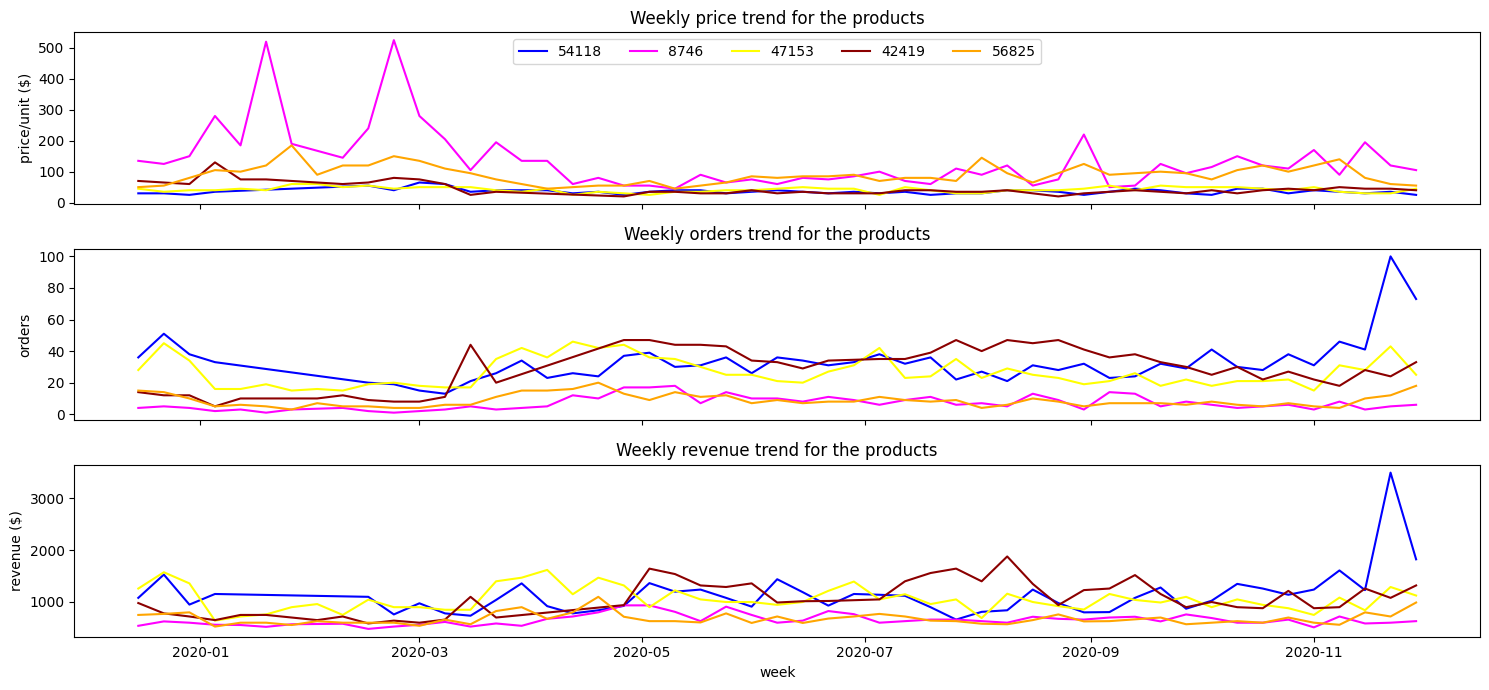

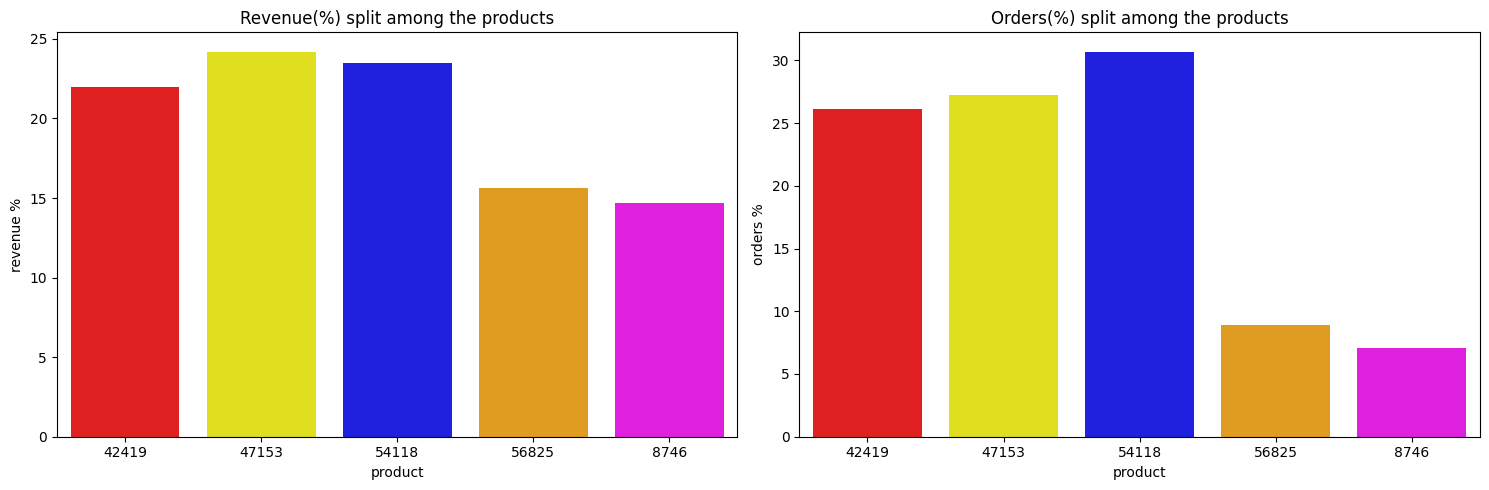

In [ ]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import warnings
warnings.filterwarnings('ignore')

class ProductAnalytics:
    def __init__(self, data_file):
        self.df = pd.read_excel(data_file, sheet_name='data')
        self.df_dict = pd.read_excel(data_file, sheet_name='dictionary')

        self.clean_data()

    def clean_data(self):
        self.df['product'] = self.df['product'].astype(str)
        self.df.week = pd.to_datetime(self.df.week)
        self.df.dropna(inplace=True)
        self.df['inv_sow'] = self.df.groupby(['product'])['inventory'].shift(1)
        self.df.dropna(inplace=True)
        self.df['inv_rep'] = self.df.inventory + self.df.orders - self.df.inv_sow
        inv_hld_cst = 0.1
        self.df['inv_cost'] = round(self.df.price * self.df.inventory * inv_hld_cst, 2)
        self.df['revenue'] = self.df.price * self.df.orders
        convert_dict = {'orders': int, 'views': int, 'cart_adds': int, 'inv_sow': int, 'inv_rep': int}
        self.df = self.df.astype(convert_dict)

    def trend(self, products):
        def filter_by_product(product):
            return self.df[(self.df['orders'] > 0) & ((self.df['inv_sow'] + self.df['inv_rep']) >= self.df['orders']) & (self.df['product'] == product)]

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15, 7))
        for product, color in zip(products, ['blue', 'magenta', 'yellow', 'darkred', 'orange']):
            ax1.plot(filter_by_product(product).week, filter_by_product(product).price, color)
            ax2.plot(filter_by_product(product).week, filter_by_product(product).orders, color)
            ax3.plot(filter_by_product(product).week, filter_by_product(product).revenue, color)

        ax1.legend(products, ncol=len(products), loc='upper center')
        ax1.set_title('Weekly price trend for the products')
        ax1.set(ylabel='price/unit ($)')
        ax2.set_title('Weekly orders trend for the products')
        ax2.set(ylabel='orders')
        ax3.set_title('Weekly revenue trend for the products')
        ax3.set(xlabel='week', ylabel='revenue ($)')

        plt.tight_layout()
        return fig

    def plot_revenue_orders_split(self):
        df_rev = round(pd.pivot_table(self.df, index='product', values='revenue', aggfunc=np.sum) * 100 / sum(self.df.revenue), 1)
        df_rev.columns = ['revenue %']
        df_rev.reset_index(inplace=True)

        df_ord = round(pd.pivot_table(self.df, index='product', values='orders', aggfunc=np.sum) * 100 / sum(self.df.orders), 1)
        df_ord.columns = ['orders %']
        df_ord.reset_index(inplace=True)

        fig = plt.figure(figsize=(15, 5))
        my_pal = {'54118': 'blue', '8746': 'magenta', '47153': 'yellow', '42419': 'red', '56825': 'orange'}

        ax = fig.add_subplot(1, 2, 1)
        sns.barplot(x="product", y="revenue %", data=df_rev, palette=my_pal)
        plt.title('Revenue(%) split among the products')

        ax = fig.add_subplot(1, 2, 2)
        sns.barplot(x="product", y="orders %", data=df_ord, palette=my_pal)
        plt.title('Orders(%) split among the products')

        plt.tight_layout()
        return fig

# Example usage:
products_to_analyze = ['54118', '8746', '47153', '42419', '56825']
data_file = 'Data_Science_Assignment.xlsx'

product_analytics = ProductAnalytics(data_file)

# Plotting trends for selected products
trend_fig = product_analytics.trend(products_to_analyze)
trend_fig.savefig('weekly_trends.png')  # Save figure as an image

# Plotting revenue and orders split
split_fig = product_analytics.plot_revenue_orders_split()
split_fig.savefig('revenue_orders_split.png')  # Save figure as an image

plt.show()

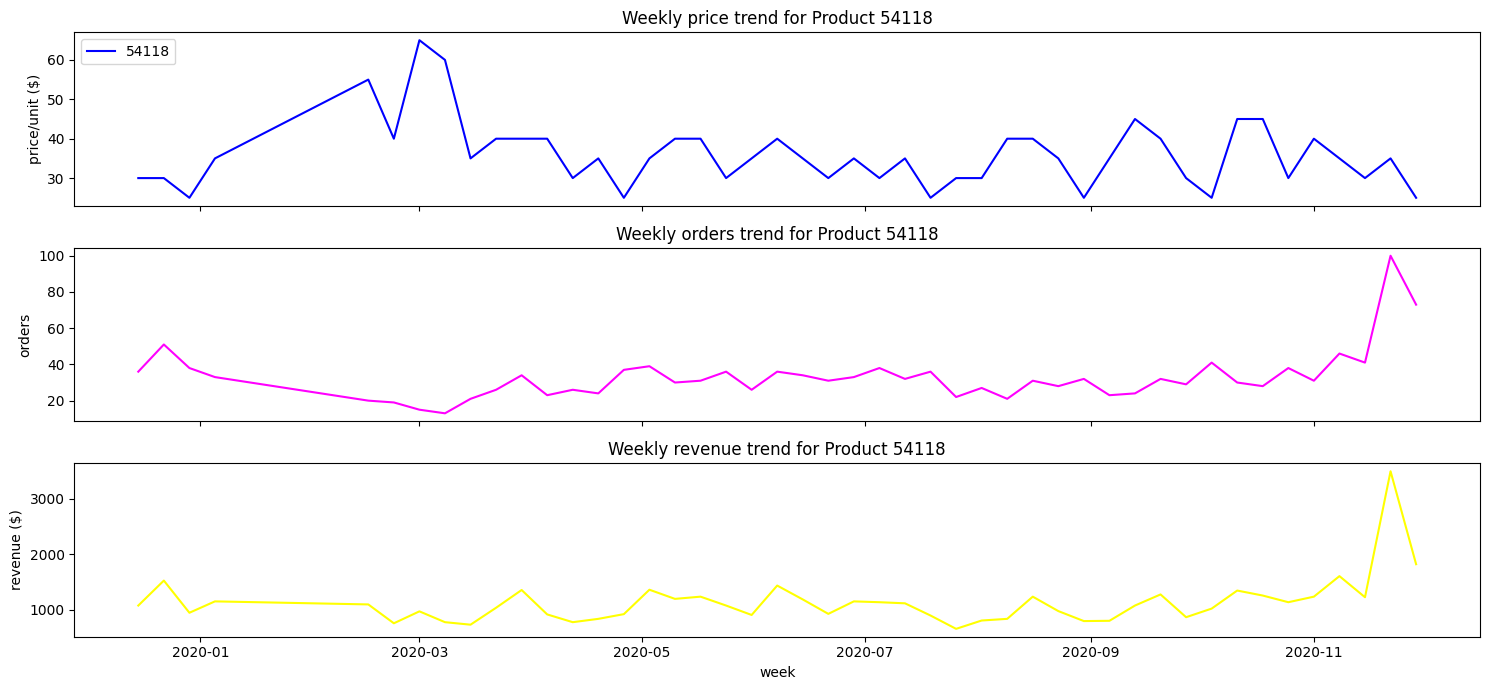

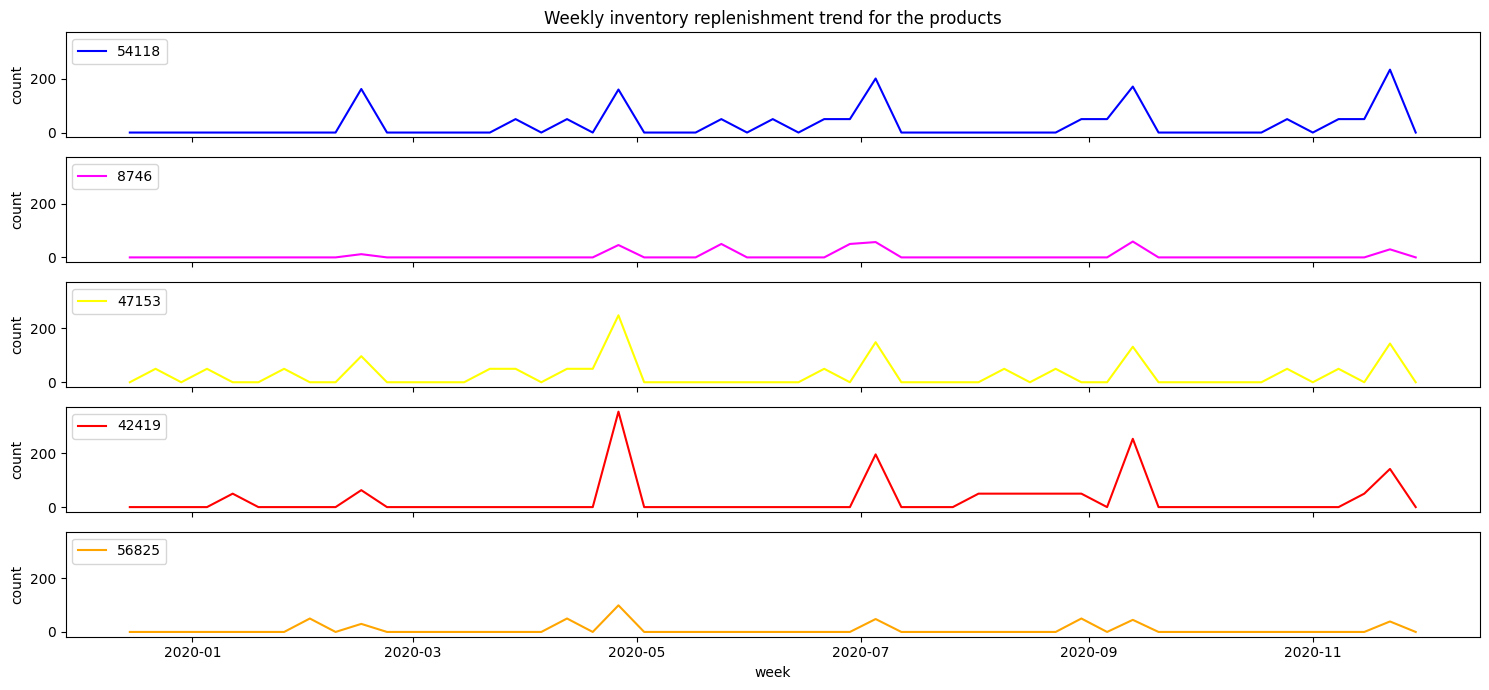

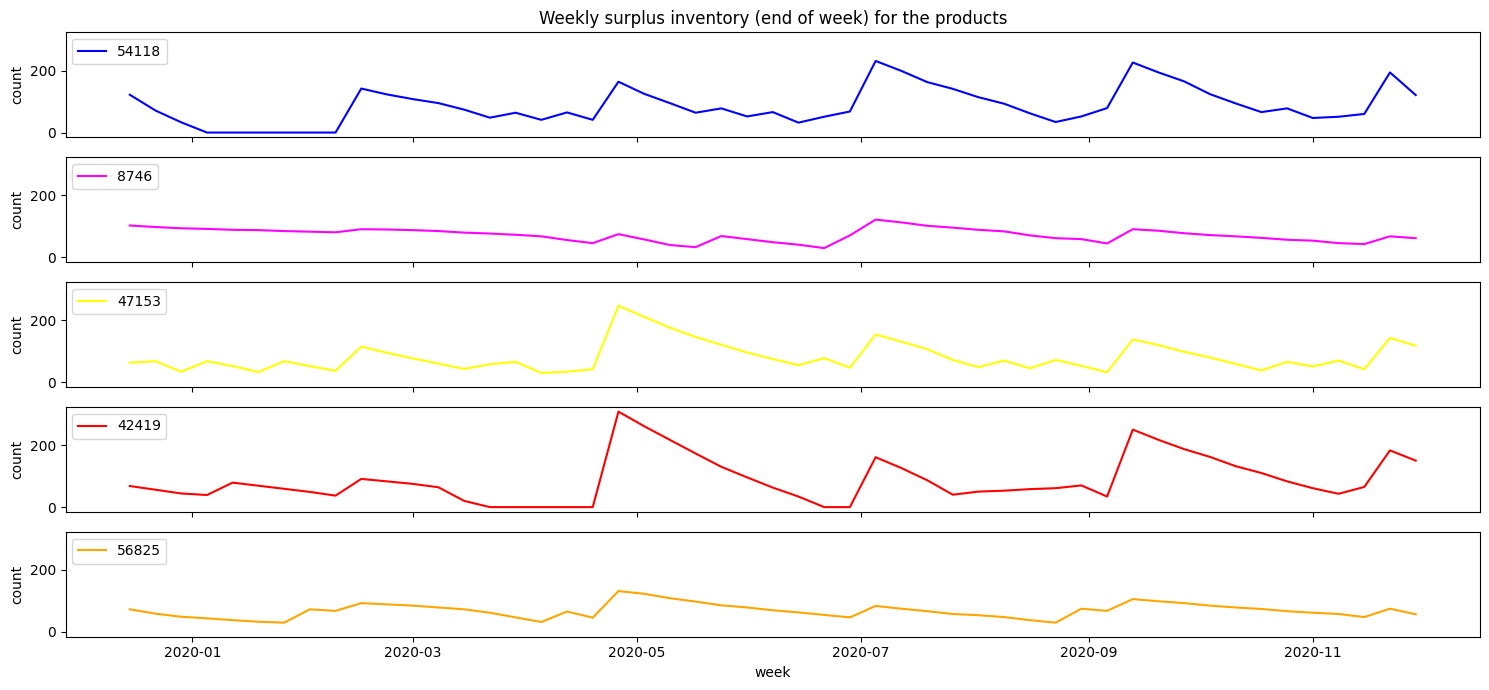

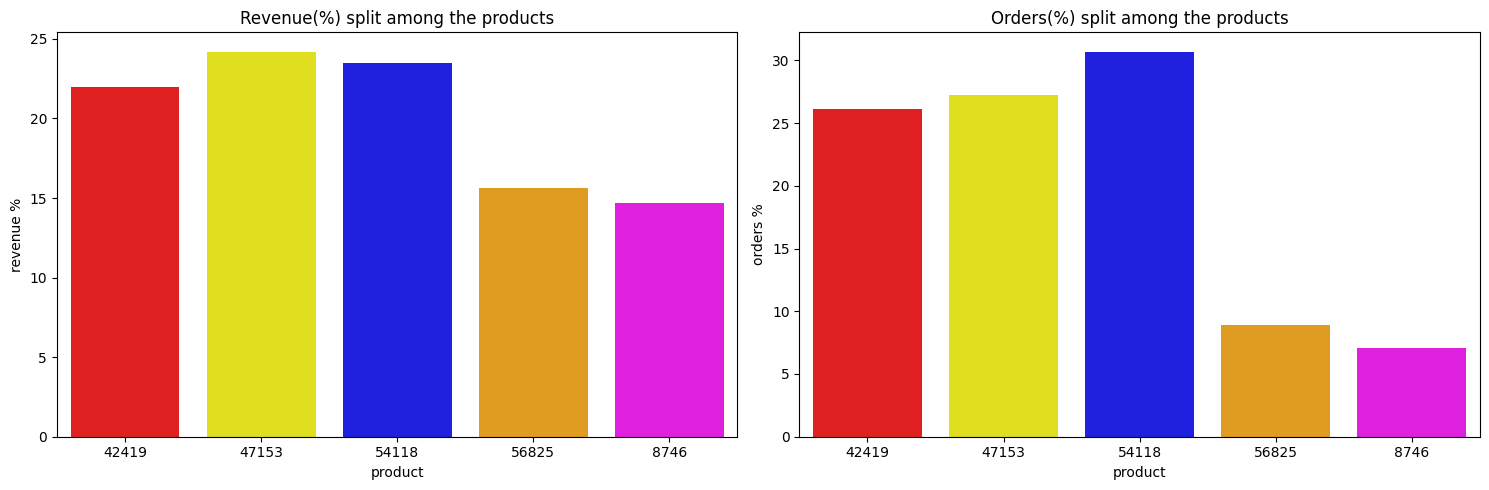

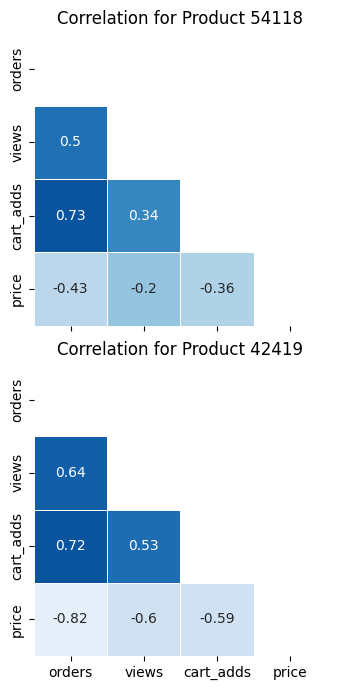

In [ ]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import warnings
warnings.filterwarnings('ignore')

class ProductAnalytics:
    def __init__(self, data_file):
        self.df = pd.read_excel(data_file, sheet_name='data')
        self.df_dict = pd.read_excel(data_file, sheet_name='dictionary')

        self.clean_data()

    def clean_data(self):
        self.df['product'] = self.df['product'].astype(str)
        self.df.week = pd.to_datetime(self.df.week)
        self.df.dropna(inplace=True)
        self.df['inv_sow'] = self.df.groupby(['product'])['inventory'].shift(1)
        self.df.dropna(inplace=True)
        self.df['inv_rep'] = self.df.inventory + self.df.orders - self.df.inv_sow
        inv_hld_cst = 0.1
        self.df['inv_cost'] = round(self.df.price * self.df.inventory * inv_hld_cst, 2)
        self.df['revenue'] = self.df.price * self.df.orders
        convert_dict = {'orders': int, 'views': int, 'cart_adds': int, 'inv_sow': int, 'inv_rep': int}
        self.df = self.df.astype(convert_dict)

    def trend(self, product):
        def filter_by_product(prd):
            return self.df[(self.df['orders'] > 0) & ((self.df['inv_sow'] + self.df['inv_rep']) >= self.df['orders']) & (self.df['product'] == prd)]

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15, 7))
        ax1.plot(filter_by_product(product).week, filter_by_product(product).price, 'blue')
        ax2.plot(filter_by_product(product).week, filter_by_product(product).orders, 'magenta')
        ax3.plot(filter_by_product(product).week, filter_by_product(product).revenue, 'yellow')

        ax1.legend([product], loc='upper left')
        ax1.set_title(f'Weekly price trend for Product {product}')
        ax1.set(ylabel='price/unit ($)')
        ax2.set_title(f'Weekly orders trend for Product {product}')
        ax2.set(ylabel='orders')
        ax3.set_title(f'Weekly revenue trend for Product {product}')
        ax3.set(xlabel='week', ylabel='revenue ($)')

        plt.tight_layout()
        return fig

    def plot_inventory_replenishment(self, products):
        def prd(prd):
            return self.df[self.df['product'] == prd]

        fig, axes = plt.subplots(len(products), 1, sharex=True, sharey=True, figsize=(15, 7))

        for ax, product, color in zip(axes, products, ['blue', 'magenta', 'yellow', 'red', 'orange']):
            ax.plot(prd(product).week, prd(product).inv_rep, color)
            ax.legend([product], loc='upper left')
            ax.set(ylabel='count')

        axes[0].set_title('Weekly inventory replenishment trend for the products')
        axes[-1].set(xlabel='week', ylabel='count')

        plt.tight_layout()
        return fig

    def plot_surplus_inventory(self, products):
        def prd(prd):
            return self.df[self.df['product'] == prd]

        fig, axes = plt.subplots(len(products), 1, sharex=True, sharey=True, figsize=(15, 7))

        for ax, product, color in zip(axes, products, ['blue', 'magenta', 'yellow', 'red', 'orange']):
            ax.plot(prd(product).week, prd(product).inventory, color)
            ax.legend([product], loc='upper left')
            ax.set(ylabel='count')

        axes[0].set_title('Weekly surplus inventory (end of week) for the products')
        axes[-1].set(xlabel='week', ylabel='count')

        plt.tight_layout()
        return fig

    def plot_revenue_orders_split(self):
        df_rev = round(pd.pivot_table(self.df, index='product', values='revenue', aggfunc=np.sum) * 100 / sum(self.df.revenue), 1)
        df_rev.columns = ['revenue %']
        df_rev.reset_index(inplace=True)

        df_ord = round(pd.pivot_table(self.df, index='product', values='orders', aggfunc=np.sum) * 100 / sum(self.df.orders), 1)
        df_ord.columns = ['orders %']
        df_ord.reset_index(inplace=True)

        fig = plt.figure(figsize=(15, 5))
        my_pal = {'54118': 'blue', '8746': 'magenta', '47153': 'yellow', '42419': 'red', '56825': 'orange'}

        ax = fig.add_subplot(1, 2, 1)
        sns.barplot(x="product", y="revenue %", data=df_rev, palette=my_pal)
        plt.title('Revenue(%) split among the products')

        ax = fig.add_subplot(1, 2, 2)
        sns.barplot(x="product", y="orders %", data=df_ord, palette=my_pal)
        plt.title('Orders(%) split among the products')

        plt.tight_layout()
        return fig

    def plot_correlation_heatmap(self, products):
        def trend(prd):
            return self.df[(self.df['orders'] > 0) & ((self.df['inv_sow'] + self.df['inv_rep']) >= self.df['orders']) & (self.df['product'] == prd)]

        fig, axes = plt.subplots(len(products), 1, sharex=True, sharey=True, figsize=(15, 7))

        for ax, product in zip(axes, products):
            df_corr = round(trend(product)[['orders', 'views', 'cart_adds', 'price']].corr(), 2)
            mask = np.zeros_like(df_corr)
            mask[np.triu_indices_from(mask)] = True

            sns.heatmap(df_corr, mask=mask, vmin=-1, vmax=1, square=True, annot=True, linewidths=.5, cmap=plt.cm.Blues, ax=ax, cbar=False)
            ax.set_title(f'Correlation for Product {product}')

        plt.tight_layout()
        return fig


# Example usage:
data_file = 'Data_Science_Assignment.xlsx'
products_to_analyze = ['54118', '8746', '47153', '42419', '56825']

product_analytics = ProductAnalytics(data_file)

# Plotting trends for selected products
trend_fig = product_analytics.trend('54118')
trend_fig.savefig('weekly_trend_54118.png')  # Save figure as an image

# Plotting inventory replenishment for selected products
inv_rep_fig = product_analytics.plot_inventory_replenishment(products_to_analyze)
inv_rep_fig.savefig('inventory_replenishment_trends.png')  # Save figure as an image

# Plotting surplus inventory for selected products
surplus_inv_fig = product_analytics.plot_surplus_inventory(products_to_analyze)
surplus_inv_fig.savefig('surplus_inventory_trends.png')  # Save figure as an image

# Plotting revenue and orders split
split_fig = product_analytics.plot_revenue_orders_split()
split_fig.savefig('revenue_orders_split.png')  # Save figure as an image

# Plotting correlation heatmap for selected products
corr_heatmap_fig = product_analytics.plot_correlation_heatmap(['54118', '42419'])
corr_heatmap_fig.savefig('correlation_heatmap.png')  # Save figure as an image

plt.show()


TypeError: 'Figure' object is not subscriptable

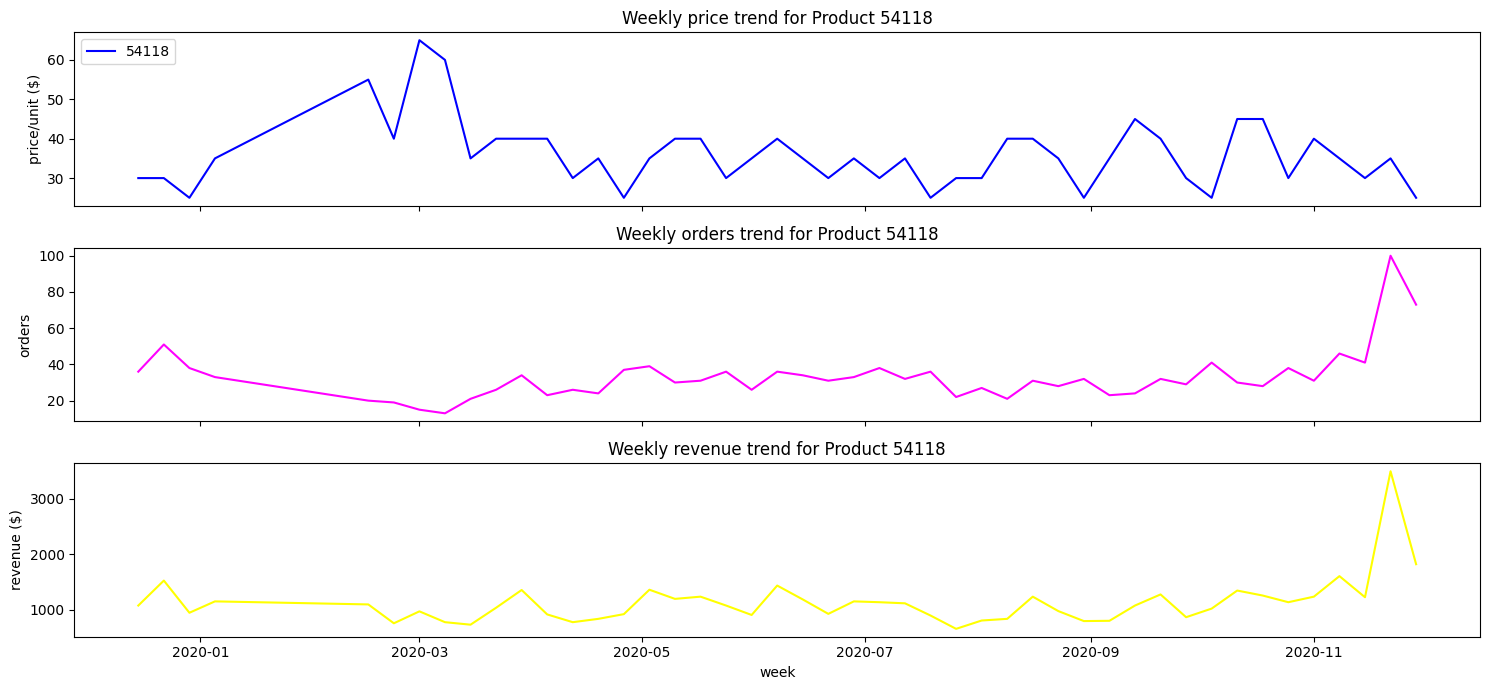

In [ ]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import warnings
warnings.filterwarnings('ignore')

class ProductAnalytics:
    def __init__(self, data_file):
        self.df = pd.read_excel(data_file, sheet_name='data')
        self.df_dict = pd.read_excel(data_file, sheet_name='dictionary')

        self.clean_data()

    def clean_data(self):
        self.df['product'] = self.df['product'].astype(str)
        self.df.week = pd.to_datetime(self.df.week)
        self.df.dropna(inplace=True)
        self.df['inv_sow'] = self.df.groupby(['product'])['inventory'].shift(1)
        self.df.dropna(inplace=True)
        self.df['inv_rep'] = self.df.inventory + self.df.orders - self.df.inv_sow
        inv_hld_cst = 0.1
        self.df['inv_cost'] = round(self.df.price * self.df.inventory * inv_hld_cst, 2)
        self.df['revenue'] = self.df.price * self.df.orders
        convert_dict = {'orders': int, 'views': int, 'cart_adds': int, 'inv_sow': int, 'inv_rep': int}
        self.df = self.df.astype(convert_dict)

    def trend(self, product):
        def filter_by_product(prd):
            return self.df[(self.df['orders'] > 0) & ((self.df['inv_sow'] + self.df['inv_rep']) >= self.df['orders']) & (self.df['product'] == prd)]

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15, 7))
        ax1.plot(filter_by_product(product).week, filter_by_product(product).price, 'blue')
        ax2.plot(filter_by_product(product).week, filter_by_product(product).orders, 'magenta')
        ax3.plot(filter_by_product(product).week, filter_by_product(product).revenue, 'yellow')

        ax1.legend([product], loc='upper left')
        ax1.set_title(f'Weekly price trend for Product {product}')
        ax1.set(ylabel='price/unit ($)')
        ax2.set_title(f'Weekly orders trend for Product {product}')
        ax2.set(ylabel='orders')
        ax3.set_title(f'Weekly revenue trend for Product {product}')
        ax3.set(xlabel='week', ylabel='revenue ($)')

        plt.tight_layout()
        return fig

    def plot_inventory_replenishment(self, products):
        def prd(prd):
            return self.df[self.df['product'] == prd]

        fig, axes = plt.subplots(len(products), 1, sharex=True, sharey=True, figsize=(15, 7))

        for ax, product, color in zip(axes, products, ['blue', 'magenta', 'yellow', 'red', 'orange']):
            ax.plot(prd(product).week, prd(product).inv_rep, color)
            ax.legend([product], loc='upper left')
            ax.set(ylabel='count')

        axes[0].set_title('Weekly inventory replenishment trend for the products')
        axes[-1].set(xlabel='week', ylabel='count')

        plt.tight_layout()
        return fig

    def plot_surplus_inventory(self, products):
        def prd(prd):
            return self.df[self.df['product'] == prd]

        fig, axes = plt.subplots(len(products), 1, sharex=True, sharey=True, figsize=(15, 7))

        for ax, product, color in zip(axes, products, ['blue', 'magenta', 'yellow', 'red', 'orange']):
            ax.plot(prd(product).week, prd(product).inventory, color)
            ax.legend([product], loc='upper left')
            ax.set(ylabel='count')

        axes[0].set_title('Weekly surplus inventory (end of week) for the products')
        axes[-1].set(xlabel='week', ylabel='count')

        plt.tight_layout()
        return fig

    def plot_revenue_orders_split(self):
        df_rev = round(pd.pivot_table(self.df, index='product', values='revenue', aggfunc=np.sum) * 100 / sum(self.df.revenue), 1)
        df_rev.columns = ['revenue %']
        df_rev.reset_index(inplace=True)

        df_ord = round(pd.pivot_table(self.df, index='product', values='orders', aggfunc=np.sum) * 100 / sum(self.df.orders), 1)
        df_ord.columns = ['orders %']
        df_ord.reset_index(inplace=True)

        fig = plt.figure(figsize=(15, 5))
        my_pal = {'54118': 'blue', '8746': 'magenta', '47153': 'yellow', '42419': 'red', '56825': 'orange'}

        ax = fig.add_subplot(1, 2, 1)
        sns.barplot(x="product", y="revenue %", data=df_rev, palette=my_pal)
        plt.title('Revenue(%) split among the products')

        ax = fig.add_subplot(1, 2, 2)
        sns.barplot(x="product", y="orders %", data=df_ord, palette=my_pal)
        plt.title('Orders(%) split among the products')

        plt.tight_layout()
        return fig

    def plot_correlation_heatmap(self, products):
        def trend(prd):
            return self.df[(self.df['orders'] > 0) & ((self.df['inv_sow'] + self.df['inv_rep']) >= self.df['orders']) & (self.df['product'] == prd)]

        fig, axes = plt.subplots(len(products), 1, sharex=True, sharey=True, figsize=(15, 7))

        for ax, product in zip(axes, products):
            df_corr = round(trend(product)[['orders', 'views', 'cart_adds', 'price']].corr(), 2)
            mask = np.zeros_like(df_corr)
            mask[np.triu_indices_from(mask)] = True

            sns.heatmap(df_corr, mask=mask, vmin=-1, vmax=1, square=True, annot=True, linewidths=.5, cmap=plt.cm.Blues, ax=ax, cbar=False)
            ax.set_title(f'Correlation for Product {product}')

        plt.tight_layout()
        return fig

    def ord_pred(self, prd):
        df_rf = self.trend(prd)[['orders', 'views', 'cart_adds', 'price']]
        X = df_rf.drop(['orders'], axis=1)
        Y = df_rf['orders']
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)
        rf = RandomForestRegressor(n_estimators=3, max_depth=5, random_state=123)
        rf.fit(X_train, Y_train)
        predictions = np.round(rf.predict(X_test))
        errors = abs(predictions - Y_test)
        mape = 100 * (errors / Y_test)
        accuracy = 100 - np.mean(mape)

        return rf

    def predict_orders_and_loss(self, product):
        rf_model = self.ord_pred(product)
        df_ord_pred = self.df[(self.df.orders == 0) & (self.df['product'] == product)]
        df_ord_pred['ord_pred'] = rf_model.predict(df_ord_pred[['views', 'cart_adds', 'price']])
        df_ord_pred['ord_pred'] = df_ord_pred['ord_pred'].astype('int')
        df_ord_pred['rev_lost'] = df_ord_pred['ord_pred'] * df_ord_pred['price']
        return df_ord_pred[['week', 'product', 'views', 'cart_adds', 'price', 'ord_pred', 'rev_lost']]

    def calculate_potential_rev_loss(self, product):
        df_ord_pred = self.predict_orders_and_loss(product)
        potential_rev_lost = round(sum(df_ord_pred.rev_lost))
        return potential_rev_lost

    def ts_mdl(self, prd):
        def filter_by_product(prd):
            return self.df_ts[self.df_ts['product'] == prd]

        df_mdl = filter_by_product(prd)
        df_mdl.rename(columns={'week': 'ds', 'ord_ts': 'y'}, inplace=True)
        df_mdl = df_mdl[['ds', 'y', 'brand']]
        df_mdl['brand'] = list(map(lambda x: 1 if x == "Big Cable Brand" else 0, df_mdl['brand']))

        tsm = Prophet(changepoint_prior_scale=0.5, weekly_seasonality=True)
        tsm.add_country_holidays(country_name='CA')
        tsm.add_regressor('brand')

        forecast = tsm.fit(df_mdl).predict(df_mdl[['ds', 'brand']])

        d1 = self.df_ts[self.df_ts['product'] == prd].drop(['brand', 'views', 'cart_adds', 'inv_rep'], axis=1)
        d2 = forecast[['ds', 'yhat']]
        df_merg = pd.merge(d1, d2, left_on='week', right_on='ds', how='inner')
        df_merg.drop(['ds'], axis=1, inplace=True)

        df_merg['yhat'] = df_merg['yhat'].astype('int')
        df_merg.rename(columns={'yhat': 'inv_sow_pred'}, inplace=True)

        df_merg['inv_eow_pred'] = list(map(lambda x, y: x - y if x > y else 0, df_merg.inv_sow_pred, df_merg.ord_ts))
        df_merg['inv_cost_pred'] = round(df_merg.price * df_merg.inv_eow_pred * inv_hld_cst, 2)

        df_merg['rev_loss_pred'] = list(map(lambda x, y, z: z * (y - x) if x < y else 0, df_merg.inv_sow_pred, df_merg.ord_ts, df_merg.price))

        df_sav = pd.pivot_table(df_merg, index='product', values=['inv_cost', 'rev_loss', 'inv_cost_pred', 'rev_loss_pred'], aggfunc=np.sum).astype('int')
        df_sav['potential_saving'] = (df_sav.inv_cost + df_sav.rev_loss) - (df_sav.inv_cost_pred + df_sav.rev_loss_pred)

        return df_sav, df_merg

data_file = 'Data_Science_Assignment.xlsx'
product_analytics = ProductAnalytics(data_file)

rev_lost_54118 = product_analytics.calculate_potential_rev_loss('54118')
print("Potential revenue lost for Product 54118:", rev_lost_54118)

# Calculate potential revenue lost for Product 42419
rev_lost_42419 = product_analytics.calculate_potential_rev_loss('42419')
print("Potential revenue lost for Product 42419:", rev_lost_42419)

# Perform time series modeling for all products
df_op = product_analytics.ts_mdl('54118')[0]  # Assuming ts_mdl returns the dataframe with savings
print(df_op)

plt.show()
